<a href="https://colab.research.google.com/github/guptavasu1213/glaucoma-identification/blob/master/Dataset_and_transforms_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This cell allows us to import local modules from google drive
import sys
sys.path.append('/content/drive/Shared drives/Capstone Summer 2020/Collab Files/Scripts')

In [ ]:
import os
from PIL import Image
import numpy as np
# import utils
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

In [ ]:
train_path = 'drive/Shared drives/Capstone Summer 2020/Data/Training/'
test_path = 'drive/Shared drives/Capstone Summer 2020/Data/Testing/'
#https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#torchvision-object-detection-finetuning-tutorial

class Dataset(BaseDataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.images_dir = os.path.join(root_dir, 'Images')
    self.masks_dir =os.path.join(root_dir, 'Masks')
    self.transform = transform
    self.ids = os.listdir(self.images_dir)
    self.maskids = os.listdir(self.masks_dir)

  def __getitem__(self, idx):
    #load images and masks
    img_path = os.path.join(self.images_dir, self.ids[idx])
    mask_path = os.path.join(self.masks_dir, self.maskids[idx])
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)

    sample = {'image': img, 'mask': mask}
    
    if self.transform is not None:
      sample = self.transform(sample)
    return sample
  
  def __len__(self):
    return len(self.ids)


In [ ]:
from torchvision.transforms import functional as F

class Resize(object):
  def __init__(self, img_resize):
    self.img_resize = img_resize

  def __call__(self, sample):
    image, mask = sample['image'], sample['mask']
    mask = mask.resize(self.img_resize)
    image = image.resize(self.img_resize)
    return {'image': image, 'mask': mask}


class ToTensor(object):
  def __call__(self, sample):
    image = F.to_tensor(sample['image'])
    mask = F.to_tensor(sample['mask'])
    return {'image': image, 'mask': mask}


class ToPILImage(object):
  def __call__(self, sample):
    image = F.to_pil_image(sample['image'])
    mask = F.to_pil_image(sample['mask'])
    return {'image': image, 'mask': mask}


class Normalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std
  
  def __call__(self, sample):
    # we don't need to nromailze masks
    image, mask = sample['image'], mask['mask']
    image = F.normalize(image, mean=self.mean, std=self.std)
    return {'image': image, 'mask': mask}

In [ ]:
def get_transform():
    transforms = []
    transforms.append(ToTensor()) 
    return transforms.Compose(transforms)

In [ ]:
import csv
import copy
import time
from tqdm import tqdm 
 
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    #Extracting the weights and biases from the model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    # fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
    #     [f'Train_{m}' for m in metrics.keys()] + \
    #     [f'Test_{m}' for m in metrics.keys()]
    # with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
    #     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    #     writer.writeheader()
 
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        # batchsummary = {a: [0] for a in fieldnames}
 
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
 
            # Iterate over data.
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
 
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    #Train                    
                    outputs = model(inputs)
                    #Compute loss
                    loss = criterion(outputs['out'], masks)
                    
                    #Logging the results
                    # y_pred = outputs['out'].data.cpu().numpy().ravel()
                    # y_true = masks.data.cpu().numpy().ravel()
                    # for name, metric in metrics.items():
                    #     if name == 'f1_score':
                    #         # Use a classification threshold of 0.1
                    #         batchsummary[f'{phase}_{name}'].append(
                    #             metric(y_true > 0, y_pred > 0.1))
                    #     else:
                    #         batchsummary[f'{phase}_{name}'].append(
                    #             metric(y_true.astype('uint8'), y_pred))
 
                    # Backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            # batchsummary['epoch'] = epoch
            epoch_loss = loss
            # batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        # for field in fieldnames[3:]:
        #     batchsummary[field] = np.mean(batchsummary[field])
        # print(batchsummary)
        # with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
        #     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        #     writer.writerow(batchsummary)
        #     # deep copy the model
        if phase == 'Test' and loss < best_loss:
            best_loss = loss
            best_model_wts = copy.deepcopy(model.state_dict())
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))
 
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def preprocess_image():
  return transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])

In [ ]:
def predict(img, model):
  #Preprocess the raw image
  transform = preprocess_image()
  img = transform(img)

  # Use gpu if available
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  img = img.unsqueeze(0) # create a mini-batch as expected by the model

  # img = img.view(1, 3, 512, 512)
  img = img.type(torch.cuda.FloatTensor)
  
  #Run prediction
  output = model(img)
  mask = output['out'][0]
  print(mask.shape)
  return mask

In [ ]:
def load_model():
  model = torch.load('drive/Shared drives/Capstone Summer 2020/Models/weights.pt')
  return model

In [ ]:
transform = transforms.Compose([Resize((512, 512)), ToTensor()])
# Creating test and train datasets
train_dataset = Dataset(train_path, transform=transform)
test_dataset = Dataset(test_path, transform=transform)

In [ ]:
#Creating test and train dataloaders
train_dataloader =  DataLoader (train_dataset, batch_size=2, shuffle=True, num_workers=4)
test_dataloader =  DataLoader (test_dataset, batch_size=2, shuffle=True, num_workers=4)
dataloaders = {'Train': train_dataloader, 'Test': test_dataloader}

In [ ]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score
from deeplabv3 import DeepLabHead

#Model initialization
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)

# Added a Sigmoid activation after the last convolution layer
model.classifier = DeepLabHead(2048, 1) # Specifying the output classes we need

# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Specify the evalutation metrics
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

#Training the model
# trained_model = train_model(model, criterion, dataloaders,
#                             optimizer, bpath="", metrics=metrics, num_epochs=24)

In [ ]:
# torch.save(trained_model, os.path.join('drive/Shared drives/Capstone Summer 2020/Models', 'weights.pt'))

In [ ]:
trained_model = load_model()

torch.Size([512, 512])
tensor([[0.9811, 0.9811, 0.9811,  ..., 0.9853, 0.9853, 0.9853],
        [0.9811, 0.9811, 0.9811,  ..., 0.9853, 0.9853, 0.9853],
        [0.9811, 0.9811, 0.9811,  ..., 0.9853, 0.9853, 0.9853],
        ...,
        [0.9629, 0.9629, 0.9629,  ..., 0.9853, 0.9853, 0.9853],
        [0.9629, 0.9629, 0.9629,  ..., 0.9853, 0.9853, 0.9853],
        [0.9629, 0.9629, 0.9629,  ..., 0.9853, 0.9853, 0.9853]],
       device='cuda:0', grad_fn=<SelectBackward>)
(512,)


TypeError: ignored

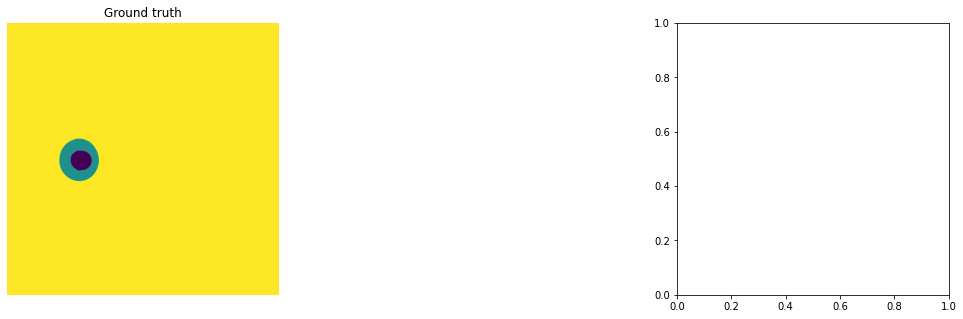

In [ ]:
# val_path = "drive/Shared drives/Capstone Summer 2020/Data/TestImage/"

# from torch.utils.data import Dataset as DDD

# val_dataset = DDD(val_path, )
# val_dataloader =  DataLoader (val_dataset, batch_size=2, shuffle=True, num_workers=4)

imageName = "V0001"

mask_path = "drive/Shared drives/Capstone Summer 2020/Data/Validation/Masks/"+ imageName +".bmp"
ground_truth = Image.open(mask_path)

img_path = "drive/Shared drives/Capstone Summer 2020/Data/Validation/Images/"+ imageName +".jpg"
img_prediction = Image.open(img_path).convert("RGB")

result_mask = predict(img_prediction, trained_model)

print(result_mask)
# mas = torch.argmax(result_mask.squeeze(), dim=1).detach().cpu().numpy()
mas = result_mask.argmax(0).detach().cpu().numpy()
print(mas.shape)
# mas = torch.max(result_mask, 1)
# out = result_mask.argmax(0)
# print(out.size())

# create a color pallette, selecting a color for each class
# palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
# colors = torch.as_tensor([i for i in range(3)])[:, None] * palette
# colors = (colors % 255).numpy().astype("uint8")


# # plot the semantic segmentation predictions of 21 classes in each color
# r = Image.fromarray(out.byte().cpu().numpy()).resize((512,512))
# r.putpalette(colors)
##

# plt.imshow(r)

# print('==' )
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(22,5))

#plot ground truth
axs[0].imshow((ground_truth))
axs[0].axis('off')   
axs[0].set_title('Ground truth')

#plot the mask
axs[1].imshow((mas))
axs[1].axis('off')   
axs[1].set_title('Mask')

# for row in result_mask:
#   # print(row)
#   if 0 not in row:
    # print("yayay")
# print(mas)

In [ ]:
a = torch.randn(4, 4)
a


tensor([[ 0.1663, -1.0868,  0.2287, -1.2824],
        [-1.3855, -0.8027, -0.3674, -0.6257],
        [ 0.2527,  2.4022,  0.2912, -0.8184],
        [ 0.6920, -0.7488,  0.9105, -0.2727]])

In [ ]:
torch.argmax(a, dim=0)


tensor([3, 2, 3, 3])

In [ ]:
torch.argmax(a, dim=1)

tensor([2, 2, 1, 2])

In [ ]:



tranny = transforms.Compose([ToPILImage()])
what = tranny(train_dataset[0])
print(what['image'])
im_running_out_of_names = what['image']
im_running_out_of_names.show()
display(im_running_out_of_names)